<a href="https://colab.research.google.com/github/ozgurshn/Colab-notebooks/blob/master/Cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CycleGan Colab sample for fastai course V3

https://www.fast.ai/

Author: [Ozgur Sahin](https://twitter.com/ozgr_shn)

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash


Updating fastai...
Done.


In [0]:
from fastai.vision import *

## Data

One-time download, uncomment the next cells to get the data.

In [0]:
#path = Config().data_path()

In [0]:
#! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -P {path}
#! unzip -q -n {path}/horse2zebra.zip -d {path}
#! rm {path}/horse2zebra.zip

In [0]:
#Download your images to a path in your drive. Make sure it has trainA and trainB folders or change the names in data loader
#Your dataset path at your drive
path = Path('/content/drive/My Drive/datasetv3/')
path.ls()

[PosixPath('/content/drive/My Drive/datasetv3/trainA'),
 PosixPath('/content/drive/My Drive/datasetv3/trainB'),
 PosixPath('/content/drive/My Drive/datasetv3/models'),
 PosixPath('/content/drive/My Drive/datasetv3/.ipynb_checkpoints'),
 PosixPath('/content/drive/My Drive/datasetv3/export.pkl'),
 PosixPath('/content/drive/My Drive/datasetv3/trainB1Channel'),
 PosixPath('/content/drive/My Drive/datasetv3/trainA1')]

See [this tutorial](https://docs.fast.ai/tutorial.itemlist.html) for a detailed walkthrough of how/why this custom `ItemList` was created.

In [0]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self
        
    def __repr__(self):
     return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'
    
    def to_one(self): return Image(0.5+torch.cat(self.data,2)/2)

In [0]:
class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

In [0]:
class ImageTupleList(ImageList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [0]:
data = None
data = (ImageTupleList.from_folders(path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size=128)
                      .databunch(bs=4))

In [0]:
len(data.train_dl)

444

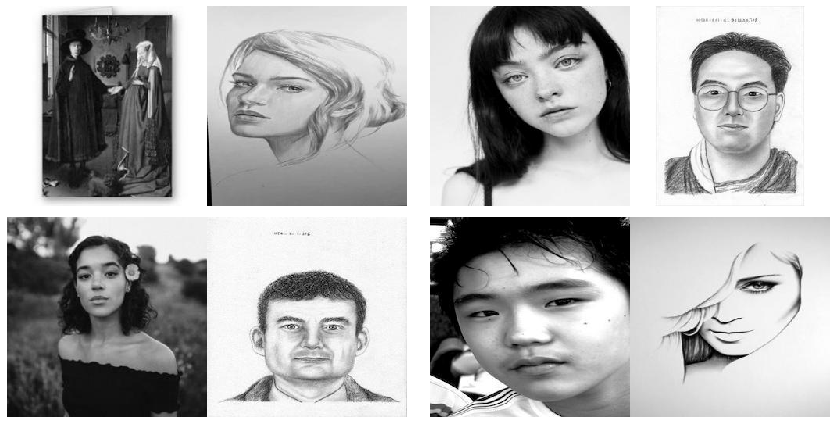

In [0]:
data.show_batch(rows=8)

## Models

We use the models that were introduced in the [cycleGAN paper](https://arxiv.org/abs/1703.10593).

In [0]:
def convT_norm_relu(ch_in:int, ch_out:int, norm_layer:nn.Module, ks:int=3, stride:int=2, bias:bool=True):
    return [nn.ConvTranspose2d(ch_in, ch_out, kernel_size=ks, stride=stride, padding=1, output_padding=1, bias=bias),
            norm_layer(ch_out), nn.ReLU(True)]

In [0]:
def pad_conv_norm_relu(ch_in:int, ch_out:int, pad_mode:str, norm_layer:nn.Module, ks:int=3, bias:bool=True, 
                       pad=1, stride:int=1, activ:bool=True, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    layers = []
    if pad_mode == 'reflection': layers.append(nn.ReflectionPad2d(pad))
    elif pad_mode == 'border':   layers.append(nn.ReplicationPad2d(pad))
    p = pad if pad_mode == 'zeros' else 0
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=p, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers += [conv, norm_layer(ch_out)]
    if activ: layers.append(nn.ReLU(inplace=True))
    return layers

In [0]:
class ResnetBlock(nn.Module):
    def __init__(self, dim:int, pad_mode:str='reflection', norm_layer:nn.Module=None, dropout:float=0., bias:bool=True):
        super().__init__()
        assert pad_mode in ['zeros', 'reflection', 'border'], f'padding {pad_mode} not implemented.'
        norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
        layers = pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias)
        if dropout != 0: layers.append(nn.Dropout(dropout))
        layers += pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias=bias, activ=False)
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x): return x + self.conv_block(x)

In [0]:
def resnet_generator(ch_in:int, ch_out:int, n_ftrs:int=64, norm_layer:nn.Module=None, 
                     dropout:float=0., n_blocks:int=6, pad_mode:str='reflection')->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = pad_conv_norm_relu(ch_in, n_ftrs, 'reflection', norm_layer, pad=3, ks=7, bias=bias)
    for i in range(2):
        layers += pad_conv_norm_relu(n_ftrs, n_ftrs *2, 'zeros', norm_layer, stride=2, bias=bias)
        n_ftrs *= 2
    layers += [ResnetBlock(n_ftrs, pad_mode, norm_layer, dropout, bias) for _ in range(n_blocks)]
    for i in range(2):
        layers += convT_norm_relu(n_ftrs, n_ftrs//2, norm_layer, bias=bias)
        n_ftrs //= 2
    layers += [nn.ReflectionPad2d(3), nn.Conv2d(n_ftrs, ch_out, kernel_size=7, padding=0), nn.Tanh()]
    return nn.Sequential(*layers)

In [0]:
resnet_generator(3, 3)

Sequential(
  (0): ReflectionPad2d((3, 3, 3, 3))
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (9): ReLU(inplace=True)
  (10): ResnetBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    

In [0]:
def conv_norm_lr(ch_in:int, ch_out:int, norm_layer:nn.Module=None, ks:int=3, bias:bool=True, pad:int=1, stride:int=1, 
                 activ:bool=True, slope:float=0.2, init:Callable=nn.init.kaiming_normal_)->List[nn.Module]:
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=ks, padding=pad, stride=stride, bias=bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers = [conv]
    if norm_layer is not None: layers.append(norm_layer(ch_out))
    if activ: layers.append(nn.LeakyReLU(slope, inplace=True))
    return layers

In [0]:
def discriminator(ch_in:int, n_ftrs:int=64, n_layers:int=3, norm_layer:nn.Module=None, sigmoid:bool=False)->nn.Module:
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = conv_norm_lr(ch_in, n_ftrs, ks=4, stride=2, pad=1)
    for i in range(n_layers-1):
        new_ftrs = 2*n_ftrs if i <= 3 else n_ftrs
        layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=4, stride=2, pad=1, bias=bias)
        n_ftrs = new_ftrs
    new_ftrs = 2*n_ftrs if n_layers <=3 else n_ftrs
    layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, ks=4, stride=1, pad=1, bias=bias)
    layers.append(nn.Conv2d(new_ftrs, 1, kernel_size=4, stride=1, padding=1))
    if sigmoid: layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [0]:
discriminator(3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

We group two discriminators and two generators in a single model, then a `Callback` will take care of training them properly.

In [0]:
class CycleGAN(nn.Module):
    
    def __init__(self, ch_in:int, ch_out:int, n_features:int=64, disc_layers:int=3, gen_blocks:int=6, lsgan:bool=True, 
                 drop:float=0., norm_layer:nn.Module=None):
        super().__init__()
        self.D_A = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
        self.D_B = discriminator(ch_in, n_features, disc_layers, norm_layer, sigmoid=not lsgan)
        self.G_A = resnet_generator(ch_in, ch_out, n_features, norm_layer, drop, gen_blocks)
        self.G_B = resnet_generator(ch_in, ch_out, n_features, norm_layer, drop, gen_blocks)
        #G_A: takes real input B and generates fake input A
        #G_B: takes real input A and generates fake input B
        #D_A: trained to make the difference between real input A and fake input A
        #D_B: trained to make the difference between real input B and fake input B
    
    def forward(self, real_A, real_B):
        fake_A, fake_B = self.G_A(real_B), self.G_B(real_A)
        if not self.training: return torch.cat([fake_A[:,None],fake_B[:,None]], 1)
        idt_A, idt_B = self.G_A(real_A), self.G_B(real_B) #Needed for the identity loss during training.
        return [fake_A, fake_B, idt_A, idt_B]

`AdaptiveLoss` is a wrapper around a PyTorch loss function to compare an output of any size with a single number (0. or 1.). It will generate a target with the same shape as the output. A discriminator returns a feature map, and we want it to predict zeros (or ones) for each feature.

In [0]:
class AdaptiveLoss(nn.Module):
    def __init__(self, crit):
        super().__init__()
        self.crit = crit
    
    def forward(self, output, target:bool, **kwargs):
        targ = output.new_ones(*output.size()) if target else output.new_zeros(*output.size())
        return self.crit(output, targ, **kwargs)

The main loss used to train the generators. It has three parts:
- the classic GAN loss: they must make the critics believe their images are real
- identity loss: if they are given an image from the set they are trying to imitate, they should return the same thing
- cycle loss: if an image from A goes through the generator that imitates B then through the generator that imitates A, it should be the same as the initial image. Same for B and switching the generators

In [0]:
class CycleGanLoss(nn.Module):
    
    def __init__(self, cgan:nn.Module, lambda_A:float=10., lambda_B:float=10, lambda_idt:float=0.5, lsgan:bool=True):
        super().__init__()
        self.cgan,self.l_A,self.l_B,self.l_idt = cgan,lambda_A,lambda_B,lambda_idt
        self.crit = AdaptiveLoss(F.mse_loss if lsgan else F.binary_cross_entropy)
    
    def set_input(self, input):
        self.real_A,self.real_B = input
    
    def forward(self, output, target):
        fake_A, fake_B, idt_A, idt_B = output
        #Generators should return identity on the datasets they try to convert to
        self.id_loss = self.l_idt * (self.l_A * F.l1_loss(idt_A, self.real_A) + self.l_B * F.l1_loss(idt_B, self.real_B))
        #Generators are trained to trick the discriminators so the following should be ones
        self.gen_loss = self.crit(self.cgan.D_A(fake_A), True) + self.crit(self.cgan.D_B(fake_B), True)
        #Cycle loss
        self.cyc_loss  = self.l_A * F.l1_loss(self.cgan.G_A(fake_B), self.real_A)
        self.cyc_loss += self.l_B * F.l1_loss(self.cgan.G_B(fake_A), self.real_B)
        return self.id_loss+self.gen_loss+  self.cyc_loss

The main callback to train a cycle GAN. The training loop will train the generators (so `learn.opt` is given those parameters) while the critics are trained by the callback during `on_batch_end`.

In [0]:
class CycleGANTrainer(LearnerCallback):
    _order = -20 #Need to run before the Recorder
    
    def _set_trainable(self, D_A=False, D_B=False):
        gen = (not D_A) and (not D_B)
        requires_grad(self.learn.model.G_A, gen)
        requires_grad(self.learn.model.G_B, gen)
        requires_grad(self.learn.model.D_A, D_A)
        requires_grad(self.learn.model.D_B, D_B)
        if not gen:
            self.opt_D_A.lr, self.opt_D_A.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_D_A.wd, self.opt_D_A.beta = self.learn.opt.wd, self.learn.opt.beta
            self.opt_D_B.lr, self.opt_D_B.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_D_B.wd, self.opt_D_B.beta = self.learn.opt.wd, self.learn.opt.beta
    
    def on_train_begin(self, **kwargs):
        self.G_A,self.G_B = self.learn.model.G_A,self.learn.model.G_B
        self.D_A,self.D_B = self.learn.model.D_A,self.learn.model.D_B
        self.crit = self.learn.loss_func.crit
        if not getattr(self,'opt_G',None):
            self.opt_G = self.learn.opt.new([nn.Sequential(*flatten_model(self.G_A), *flatten_model(self.G_B))])
        else: 
            self.opt_G.lr,self.opt_G.wd = self.opt.lr,self.opt.wd
            self.opt_G.mom,self.opt_G.beta = self.opt.mom,self.opt.beta
        if not getattr(self,'opt_D_A',None):
            self.opt_D_A = self.learn.opt.new([nn.Sequential(*flatten_model(self.D_A))])
        if not getattr(self,'opt_D_B',None):
            self.opt_D_B = self.learn.opt.new([nn.Sequential(*flatten_model(self.D_B))])
        self.learn.opt.opt = self.opt_G.opt
        self._set_trainable()
        self.id_smter,self.gen_smter,self.cyc_smter = SmoothenValue(0.98),SmoothenValue(0.98),SmoothenValue(0.98)
        self.da_smter,self.db_smter = SmoothenValue(0.98),SmoothenValue(0.98)
        self.recorder.add_metric_names(['id_loss', 'gen_loss', 'cyc_loss', 'D_A_loss', 'D_B_loss'])
        
    def on_batch_begin(self, last_input, **kwargs):
        self.learn.loss_func.set_input(last_input)
    
    def on_backward_begin(self, **kwargs):
        self.id_smter.add_value(self.loss_func.id_loss.detach().cpu())
        self.gen_smter.add_value(self.loss_func.gen_loss.detach().cpu())
        self.cyc_smter.add_value(self.loss_func.cyc_loss.detach().cpu())
    
    def on_batch_end(self, last_input, last_output, **kwargs):
        self.G_A.zero_grad(); self.G_B.zero_grad()
        fake_A, fake_B = last_output[0].detach(), last_output[1].detach()
        real_A, real_B = last_input
        self._set_trainable(D_A=True)
        self.D_A.zero_grad()
        loss_D_A = 0.5 * (self.crit(self.D_A(real_A), True) + self.crit(self.D_A(fake_A), False))
        self.da_smter.add_value(loss_D_A.detach().cpu())
        loss_D_A.backward()
        self.opt_D_A.step()
        self._set_trainable(D_B=True)
        self.D_B.zero_grad()
        loss_D_B = 0.5 * (self.crit(self.D_B(real_B), True) + self.crit(self.D_B(fake_B), False))
        self.db_smter.add_value(loss_D_B.detach().cpu())
        loss_D_B.backward()
        self.opt_D_B.step()
        self._set_trainable()
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, [s.smooth for s in [self.id_smter,self.gen_smter,self.cyc_smter,
                                                             self.da_smter,self.db_smter]])

## Training

In [0]:
 from fastai.callbacks import SaveModelCallback

 learn = None
 data.train_dl = data.train_dl.new(shuffle=True)
 
 cycle_gan = CycleGAN(3,3, gen_blocks=9)
 learn = Learner(data, cycle_gan, loss_func=CycleGanLoss(cycle_gan),
                 opt_func=partial(optim.Adam, betas=(0.5,0.99)),
                 callback_fns=[CycleGANTrainer] )


In [0]:
#every improvement did not work for me for CycleGan in Colab, so I use every epoch
learn.callbacks =[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='model')]

learn.fit(100, 1e-4)

epoch,train_loss,valid_loss,id_loss,gen_loss,cyc_loss,D_A_loss,D_B_loss,time
0,1.741025,#na#,0.572907,0.058445,1.109673,0.746816,0.917168,09:25
1,1.614849,#na#,0.522622,0.063304,1.028923,0.775949,0.910031,09:25
2,1.737535,#na#,0.582816,0.069893,1.084825,0.776643,0.896288,09:26
3,1.717584,#na#,0.575147,0.072509,1.069928,0.785590,0.898493,09:25
4,1.600468,#na#,0.522353,0.061537,1.016577,0.813367,0.911154,09:25
5,1.659046,#na#,0.548922,0.067656,1.042468,0.816189,0.913491,09:25
6,1.596139,#na#,0.534657,0.055698,1.005784,0.836323,0.913519,09:25
7,1.645926,#na#,0.548567,0.070674,1.026685,0.823811,0.909718,09:25
8,1.604243,#na#,0.527189,0.067344,1.009711,0.841720,0.908173,09:25
9,1.548784,#na#,0.509697,0.065690,0.973397,0.849047,0.916342,09:26


In [0]:
#learn.load('/content/drive/My Drive/datasetv3/models/model_33')


In [0]:
#learn.unfreeze()

In [0]:
learn.export('grayscale.pkl')

In [0]:
learn.fit_one_cycle(7, 1e-6, start_epoch=0)

##Try model on batch
Now let's go through all the images of the training set and find the ones that are the best converted (according to our critics) or the worst converted.

In [0]:
len(learn.data.train_ds.items),len(learn.data.train_ds.itemsB)

In [0]:
def get_batch(filenames, tfms, **kwargs):
    samples = [open_image(fn) for fn in filenames]
    for s in samples: s = s.apply_tfms(tfms, **kwargs)
    batch = torch.stack([s.data for s in samples], 0).cuda()
    return 2. * (batch - 0.5)

In [0]:
fnames = learn.data.train_ds.items[:8]

In [0]:
x = get_batch(fnames, get_transforms()[1], size=128)

In [0]:
learn.model.eval()
tfms = get_transforms()[1]
bs = 16

In [0]:
def get_losses(fnames, gen, crit, bs=16):
    losses_in,losses_out = [],[]
    with torch.no_grad():
        for i in progress_bar(range(0, len(fnames), bs)):
            xb = get_batch(fnames[i:i+bs], tfms, size=128)
            fakes = gen(xb)
            preds_in,preds_out = crit(xb),crit(fakes)
            loss_in  = learn.loss_func.crit(preds_in, True,reduction='none')
            loss_out = learn.loss_func.crit(preds_out,True,reduction='none')
            losses_in.append(loss_in.view(loss_in.size(0),-1).mean(1))
            losses_out.append(loss_out.view(loss_out.size(0),-1).mean(1))
    return torch.cat(losses_in),torch.cat(losses_out)

In [0]:
losses_A = get_losses(data.train_ds.x.items, learn.model.G_B, learn.model.D_B)

In [0]:
#losses_B = get_losses(data.train_ds.x.itemsB, learn.model.G_A, learn.model.D_A)

In [0]:
def show_best(fnames, losses, gen, n=8):
    sort_idx = losses.argsort()
  
    _,axs = plt.subplots(n//2, 4, figsize=(12,2*n))
    print(n)
    xb = get_batch(fnames[sort_idx][:n], tfms, size=128)
    with torch.no_grad():
        fakes = gen(xb)
    xb,fakes = (1+xb)/2,(1+fakes)/2
    for i in range(n):
        axs.flatten()[2*i].imshow(xb[i].permute(1,2,0).cpu().detach().numpy())
        axs.flatten()[2*i].axis('off')
        axs.flatten()[2*i+1].imshow(fakes[i].permute(1,2,0).cpu().detach().numpy())
        axs.flatten()[2*i+1].set_title(losses[sort_idx][i].item())
        axs.flatten()[2*i+1].axis('off')

In [0]:
show_best(data.train_ds.x.items, losses_A[1].cpu(), learn.model.G_B)

In [0]:
#show_best(data.train_ds.x.itemsB, losses_B[1], learn.model.G_A)